# Hindcasting with CaSPAr-Archived ECCC forecasts

This notebook shows how to perform a streamflow hindcast, using CaSPar archived weather forecasts. It generates the hindcasts and plots them.

CaSPAr (Canadian Surface Prediction Archive) is an archive of historical ECCC forecasts developed by Juliane Mai at the University of Waterloo, Canada. More details on CaSPAr can be found here https://caspar-data.ca/.


Mai, J., Kornelsen, K.C., Tolson, B.A., Fortin, V., Gasset, N., Bouhemhem, D., Schäfer, D., Leahy, M., Anctil, F. and Coulibaly, P., 2020. The Canadian Surface Prediction Archive (CaSPAr): A Platform to Enhance Environmental Modeling in Canada and Globally. Bulletin of the American Meteorological Society, 101(3), pp.E341-E356.


In [1]:
# This entire section is cookie-cutter template to import required packages and prepare the temporary writing space.
import datetime as dt
import json
import tempfile
from pathlib import Path

import xarray as xr
import xskillscore
from clisops.core import average, subset
from matplotlib import pyplot as plt

from ravenpy import Emulator, RavenWarning
from ravenpy.extractors.new_config.forecasts import get_CASPAR_dataset
from ravenpy.new_config import commands as rc
from ravenpy.new_config.emulators import GR4JCN
from ravenpy.utilities.new_config import forecasting
from ravenpy.utilities.testdata import get_file

tmp = Path(tempfile.mkdtemp())

## Run the model simulations

Here we set model parameters somewhat arbitrarily, but you can set the parameters to the calibrated parameters as seen in the "06_Raven_calibration" notebook we previously encountered. We can then specify the start date for the hindcast ESP simulations and run the simulations.This means we need to choose the forecast (hindcast) date. Available data include May 2017 onwards.

In [2]:
# Date of the hindcast
hdate = dt.datetime(2018, 6, 1)

# Get the Forecast data from GEPS via CASPAR
ts_hindcast, _ = get_CASPAR_dataset("GEPS", hdate)

# Subset the data for the region of interest and take the mean to get a single vector
with xr.set_options(keep_attrs=True):
    ts_subset = subset.subset_shape(ts_hindcast, "salmon_river.geojson").mean(
        dim=("rlat", "rlon")
    )
ts_subset = ts_subset.resample(time="6H").nearest(
    tolerance="1H"
)  # To make the timesteps identical accross the entire duration

In [3]:
# See how many members we have available
len(ts_subset.members)

20

Now that we have the correct weather forecasts, we can setup the hydrological model for a warm-up run:

In [4]:
%%capture --no-display
# Adding this to avoid spamming warning messages for overwriting files.

# Prepare a RAVEN model run using historical data, GR4JCN in this case.
# This is a dummy run to get initial states. In a real forecast situation,
# this run would end on the day before the forecast, but process is the same.

# Here we need a file of observation data to run a simulation to generate initial conditions for our forecast.
# ts = str(
#    get_file("raven-gr4j-cemaneige/Salmon-River-Near-Prince-George_meteo_daily.nc")
# )

# TODO: We will use ERA5 data for Salmon River because it covers the correct period.
ts = "ERA5_weather_data_Salmon.nc"

# This is the model start date, on which the simulation will be launched for a certain duration
# to setup the initial states. We will then save the final states as a launching point for the
# forecasts.

start_date = dt.datetime(2000, 1, 1)
end_date = dt.datetime(2018, 6, 2)

# Define HRU to build the hydrological model
hru = {}
hru = dict(
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    hru_type="land",
)

# Set alternative names for netCDF variables
alt_names = {
    "TEMP_MIN": "tmin",
    "TEMP_MAX": "tmax",
    "PRECIP": "pr",
}

# Data types to extract from netCDF
data_type = ["TEMP_MAX", "TEMP_MIN", "PRECIP"]
data_kwds = {
    "ALL": {
        "elevation": hru["elevation"],
        "Latitude": hru["latitude"],
        "Longitude": hru["longitude"],
    },
}
# Model configuration
model_config_warmup = GR4JCN(
    params=[0.529, -3.396, 407.29, 1.072, 16.9, 0.947],
    Gauge=[
        rc.Gauge.from_nc(
            ts, data_type=data_type, alt_names=alt_names, data_kwds=data_kwds
        )
    ],
    HRUs=[hru],
    StartDate=start_date,
    EndDate=end_date,
    RunName="NB12_warmup_run",
    GlobalParameter={"AVG_ANNUAL_RUNOFF": 208.480},
)

# Run the model and get the outputs.
out1 = Emulator(config=model_config_warmup).run()


# Extract the path to the final states file that will be used as the next initial states
hotstart = out1.files["solution"]

We now have the initial states ready for the next step, which is to launch the forecasts in hindcasting mode:

In [5]:
# Explore the forecast data to see which variables we have:
display(ts_subset)

<xarray.Dataset>
Dimensions:       (time: 65, members: 20, member: 20)
Coordinates:
  * time          (time) datetime64[ns] 2018-06-01 ... 2018-06-17
  * members       (members) int32 1 2 3 4 5 6 7 8 9 ... 13 14 15 16 17 18 19 20
Dimensions without coordinates: member
Data variables:
    pr            (member, time) float32 0.0 0.0 0.0 ... 0.04189 0.04189 0.04189
    tas           (member, time) float32 12.99 7.652 5.916 ... 7.588 18.52 21.4
    rotated_pole  float32 9.969e+36
    crs           float64 1.0
Attributes:
    crs:      EPSG:4326

In [6]:
%%capture --no-display

# Configure and run a new model by setting the initial states (equal to the previous run's final states) and prepare
# the configuration for the forecasts (including forecast start date, which should be equal to the final simulation
# date + 1, as well as the forecast duration.)

# We need to write the hindcast data as a file for Raven to be able to access it.
fname = tmp / "hindcast.nc"
ts_subset.to_netcdf(fname)

# We need to adjust the data_type and alt_names according to the data in the forecast:
# Set alternative names for netCDF variables
alt_names = {
    "TEMP_AVE": "tas",
    "PRECIP": "pr",
}

# Data types to extract from netCDF
data_type = ["TEMP_AVE", "PRECIP"]


# We will need to reuse this for GR4J. Update according to your needs. For example, here we will also pass
# the catchment latitude and longitude as our CaSPAr data has been averaged at the catchment scale.
# We also need to tell the model to deaccumulate the precipitation and shift it in time by 6 hours for our
# catchment (UTC timezones):
data_kwds = {
    "ALL": {
        "elevation": hru["elevation"],
        "Latitude": hru["latitude"],
        "Longitude": hru["longitude"],
    },
    "PRECIP": {
        "Deaccumulate": True,
        "TimeShift": -0.25,
    },
    "TEMP_AVE": {
        "TimeShift": -0.25,
    },
}


# Model configuration for forecasting, including correct start date and forecast duration
model_config_fcst = GR4JCN(
    params=[0.529, -3.396, 407.29, 1.072, 16.9, 0.947],
    Gauge=[
        rc.Gauge.from_nc(
            fname, data_type=data_type, alt_names=alt_names, data_kwds=data_kwds
        )
    ],
    HRUs=[hru],
    StartDate=end_date + dt.timedelta(days=1),
    Duration=7,
    RunName="NB12_forecast_run",
    GlobalParameter={"AVG_ANNUAL_RUNOFF": 208.480},
)

# Update the initial states
model_config_fcst = model_config_fcst.set_solution(hotstart)

# Generate the hindcast by providing all necessary information to generate virtual stations representing
# the forecast members
hindcast = forecasting.hindcast_from_meteo_forecast(
    model_config_fcst,
    forecast=fname,
    # We also need to provide the necessary information to create gauges inside the forecasting model:
    data_kwds=data_kwds,
    data_type=data_type,
    alt_names=alt_names,
)

In [8]:
print(model_config_fcst.rvt)

:Gauge Gauge_1
  :Latitude             54.4848
  :Longitude            -123.3659
  :Elevation            843.0

  :Data TEMP_AVE deg_C
    :ReadFromNetCDF
      :FileNameNC           /tmp/tmpnft274qb/hindcast.nc
      :VarNameNC            tas
      :DimNamesNC           member time
      :StationIdx           1
      :TimeShift            -0.25
    :EndReadFromNetCDF
  :EndData

  :Data PRECIP m
    :ReadFromNetCDF
      :FileNameNC           /tmp/tmpnft274qb/hindcast.nc
      :VarNameNC            pr
      :DimNamesNC           member time
      :StationIdx           1
      :TimeShift            -0.25
      :LinearTransform 4000.000000000000000 0.000000000000000
      :Deaccumulate
    :EndReadFromNetCDF
  :EndData
:EndGauge



Explore the hindcast data:

In [9]:
hindcast.hydrograph

<xarray.Dataset>
Dimensions:     (time: 8, member: 20, nbasins: 1)
Coordinates:
  * time        (time) datetime64[ns] 2018-06-02 2018-06-03 ... 2018-06-09
    basin_name  (nbasins) object 'sub_001'
Dimensions without coordinates: member, nbasins
Data variables:
    precip      (member, time) float64 nan 9.022 9.955 ... 138.6 138.6 138.9
    q_sim       (member, time, nbasins) float64 5.718 6.234 ... 994.5 1.29e+03
    q_obs       (member, time, nbasins) float64 nan nan nan nan ... nan nan nan
    q_in        (member, time, nbasins) float64 nan nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.6
    featureType:  timeSeries
    history:      Created by Raven
    description:  Standard Output


And, for visual representation of the forecasts:


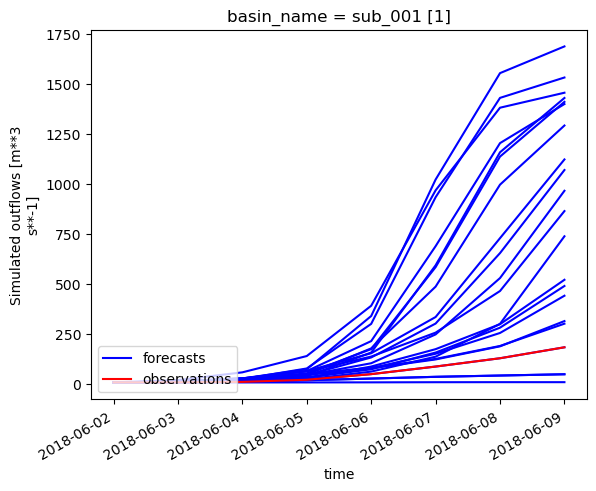

In [10]:
import matplotlib.pyplot as plt

# Simulate an observed streamflow timeseries: Here we take a member from the ensemble, but you should use your own
# observed timeseries:
qq = hindcast.hydrograph.q_sim[0, :, 0]

# This is to be replaced with a call to the forecast graphing WPS as soon as merged.
# model.q_sim.plot.line("b", x="time")
hindcast.hydrograph.q_sim[:, :, 0].plot.line("b", x="time", add_legend=False)
hindcast.hydrograph.q_sim[1, :, 0].plot.line("b", x="time", label="forecasts")
qq.plot.line("r", x="time", label="observations")
plt.legend(loc="upper left")
plt.show()